# This notebook plots the snapshots of OBS & Model Tb for a given time

In [29]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from scipy.ndimage import gaussian_filter
import copy
import seaborn as sns
# from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
import colorcet as cc
import warnings
%matplotlib inline

In [44]:
# PHASE = 'Summer'
PHASE = 'Winter'

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined/'

if PHASE == 'Summer':
    # sample_times = pd.to_datetime(['2016-08-01T00', '2016-08-10T00'])
    # sample_times = '2016-08-05T00'
    # sample_times = '2016-08-10T00'
    # sample_times = '2016-08-15T12'
    # sample_times = '2016-08-20T12'
    sample_times = '2016-08-24T18'
if PHASE == 'Winter':
    # sample_times = pd.to_datetime(['2020-01-20T00', '2020-02-01T00'])
    # sample_times = '2020-01-25T00'
    # sample_times = '2020-02-01T00'
    # sample_times = '2020-02-05T12'
    # sample_times = '2020-02-10T18'
    # sample_times = '2020-02-15T12'
    sample_times = '2020-02-20T18'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
    }

# Environmental files
olr_files = {key:f'{rootdir}/olr_pcp_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/snapshots/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/snapshots/


## Check if input files exsit

In [45]:
for key, value in olr_files.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_GRIST.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_SCREAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_XSHiELD.nc: True
/pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_GEOS.nc: True
/pscratch/sd/f/feng045/DYAMO

In [46]:
# ds1 = xr.open_dataset(olr_files['obs']).sel(time=sample_times).drop('time')
# ds1

## Function to convert OLR to Tb

In [47]:
def olr_to_tb(OLR):
    """
    Convert OLR to IR brightness temperature.

    Args:
        OLR: np.array
            Outgoing longwave radiation
    
    Returns:
        tb: np.array
            Brightness temperature
    """
    # Calculate brightness temperature
    # (1984) as given in Yang and Slingo (2001)
    # Tf = tb(a+b*Tb) where a = 1.228 and b = -1.106e-3 K^-1
    # OLR = sigma*Tf^4 
    # where sigma = Stefan-Boltzmann constant = 5.67x10^-8 W m^-2 K^-4
    a = 1.228
    b = -1.106e-3
    sigma = 5.67e-8 # W m^-2 K^-4
    tf = (OLR/sigma)**0.25
    tb = (-a + np.sqrt(a**2 + 4*b*tf))/(2*b)
    return tb

In [48]:
ds_list = []
# Loop over each file from the list
for key, value in olr_files.items():
    print(key, value)
    # Select the times
    _ds = xr.open_dataset(olr_files[key]).sel(time=sample_times).drop_dims('bnds', errors='ignore').drop('time', errors='ignore').squeeze()
    # Convert model OLR to Tb
    if (key != 'obs'):
        _ds['Tb'] = olr_to_tb(_ds['olr'])
    # Append DataSet to the list
    ds_list.append(_ds)

obs /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_OBS.nc
m1 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_ARPEGE.nc
m2 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_IFS.nc
m3 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_MPAS.nc
m4 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_NICAM.nc
m5 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_SAM.nc
m6 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_UM.nc
m7 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_GRIST.nc
m8 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_SCREAM.nc
m9 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_XSHiELD.nc
m10 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combined//olr_pcp_Winter_GEOS.nc
m11 /pscratch/sd/f/feng045/DYAMOND/OLR_Precipitation_combin

In [49]:
# Combine the DataSets
ds = xr.combine_nested(ds_list, concat_dim='source')
# Assign new coordinate 'source' using names
ds['source'] = list(name_map.keys())
lon = ds['lon']
lat = ds['lat']
ds

<xarray.Dataset>
Dimensions:        (source: 12, lat: 1200, lon: 3600)
Coordinates:
  * lat            (lat) float64 -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * lon            (lon) float64 -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * source         (source) <U3 'obs' 'm1' 'm2' 'm3' ... 'm8' 'm9' 'm10' 'm11'
Data variables:
    Tb             (source, lat, lon) float32 270.0 270.7 272.2 ... 232.9 233.4
    precipitation  (source, lat, lon) float32 0.0 0.0 ... 5.107e-13 6.177e-16
    olr            (source, lat, lon) float32 nan nan nan ... 148.7 147.9 148.9

In [50]:
# nrow = 3
# ncol = 3
# # for pp in enumerate(name_map):
# row = 0
# for pp, key in enumerate(name_map):
#     print(pp, key)

In [51]:
# 3 / nrow
# list(np.repeat(1,nrow))

In [52]:
# figsize = (16,8)

# fig = plt.figure(figsize=figsize, dpi=100)
# h_ratios = list(np.repeat(1,nrow))
# w_ratios = list(np.repeat(1,ncol))
# gs = gridspec.GridSpec(nrow, ncol, height_ratios=h_ratios, width_ratios=w_ratios)
# gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.05, hspace=0.05)

# for pp, key in enumerate(name_map):
#     print(pp, key)
#     ax = plt.subplot(gs[pp])

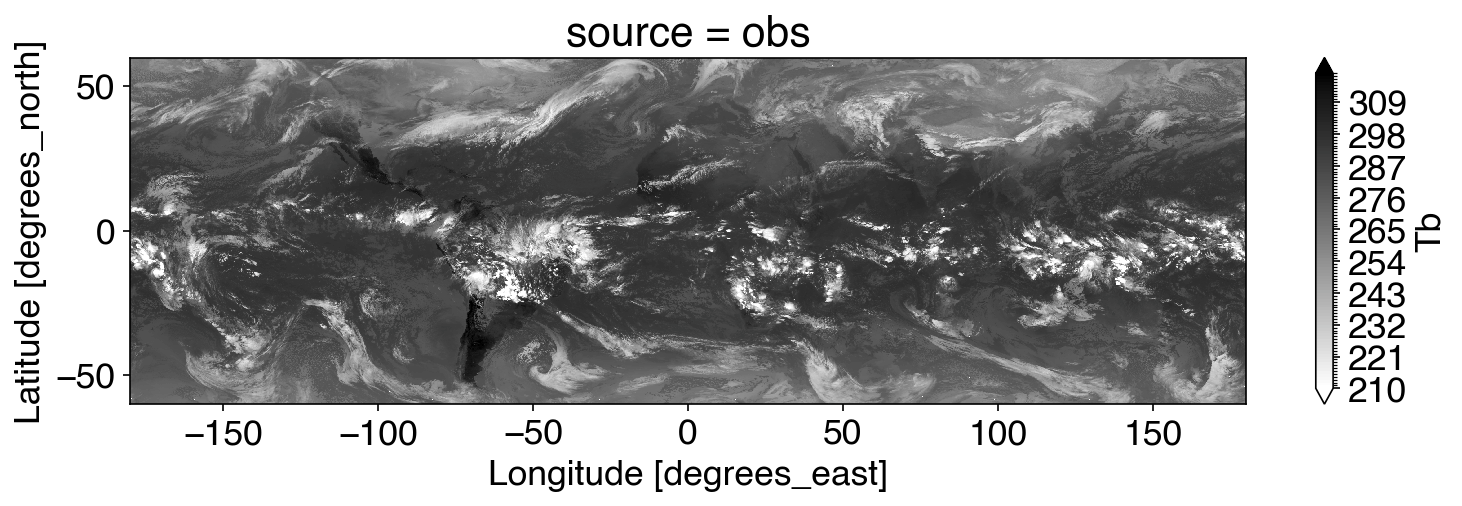

In [53]:
fig, ax = plt.subplots(1,1,figsize=(12,3), dpi=150)
levels = np.arange(210, 320, 1)
cmap = cc.cm['gray_r']
norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
ds['Tb'].sel(source='obs').plot(norm=norm, cmap=cmap, ax=ax)

## Function to plot multiple panels

In [54]:
def plot_maps_nrow(nrow, ncol, data_dict, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                   oob_colors=None, contourf=False, figsize=None, fontsize=None, cb_fontsize=None, show_cb2=False,
                   boxes=None, boxtextloc=None, dict_text_type=None, dict_text_val=None, text_colors=None, boxtext_fontsize=None):
    
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-180., 179.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=0)
    data_proj = ccrs.PlateCarree()
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=figsize, dpi=100)
    h_ratios = list(np.repeat(1,nrow))
    w_ratios = list(np.repeat(1,ncol))
    gs = gridspec.GridSpec(nrow, ncol, height_ratios=h_ratios, width_ratios=w_ratios)
    gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.02, hspace=0.05)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    for pp, key in enumerate(name_map):
        ax = plt.subplot(gs[pp], projection=proj)
        ax.set_extent(map_extent, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_aspect('auto', adjustable=None)
        # Title
        flabel = ax.text(0.02, 0.07, titles[pp], transform=ax.transAxes, fontsize=None)
        flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
        
        # Grid lines & labels
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        # gl.xlocator = mpl.ticker.FixedLocator(lonv)
        # gl.ylocator = mpl.ticker.FixedLocator(latv)         
        # if (row == nrow-1):
        #     ax.set_xticks(lonv, crs=data_proj)
        #     lon_formatter = LongitudeFormatter(zero_direction_label=True)
        #     ax.xaxis.set_major_formatter(lon_formatter)
        # ax.set_yticks(latv, crs=data_proj)
        # lat_formatter = LatitudeFormatter()
        # ax.yaxis.set_major_formatter(lat_formatter)
        
        # # Terrain height
        # ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
        #                 colors='dimgray', linewidths=1, transform=data_proj, zorder=3)
        
        # Select and mask data source
        Var = data_dict.isel(source=pp).data
        Zm = np.ma.masked_where(np.isnan(Var), Var)
        cmap = copy.copy(mpl.colormaps.get_cmap(cmaps))
        # Set out-of-bounds colors
        if oob_colors is not None:
            oob_c = oob_colors
            if oob_c is not None:
                cmap.set_over(oob_c['over'])
                cmap.set_under(oob_c['under'])
        norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
        # Plot data
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=data_proj, zorder=2)
        else:
            cf1 = ax.contourf(lon, lat, Zm, levels=levels, norm=norm, cmap=cmap, transform=data_proj, extend='both', zorder=2)
        
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

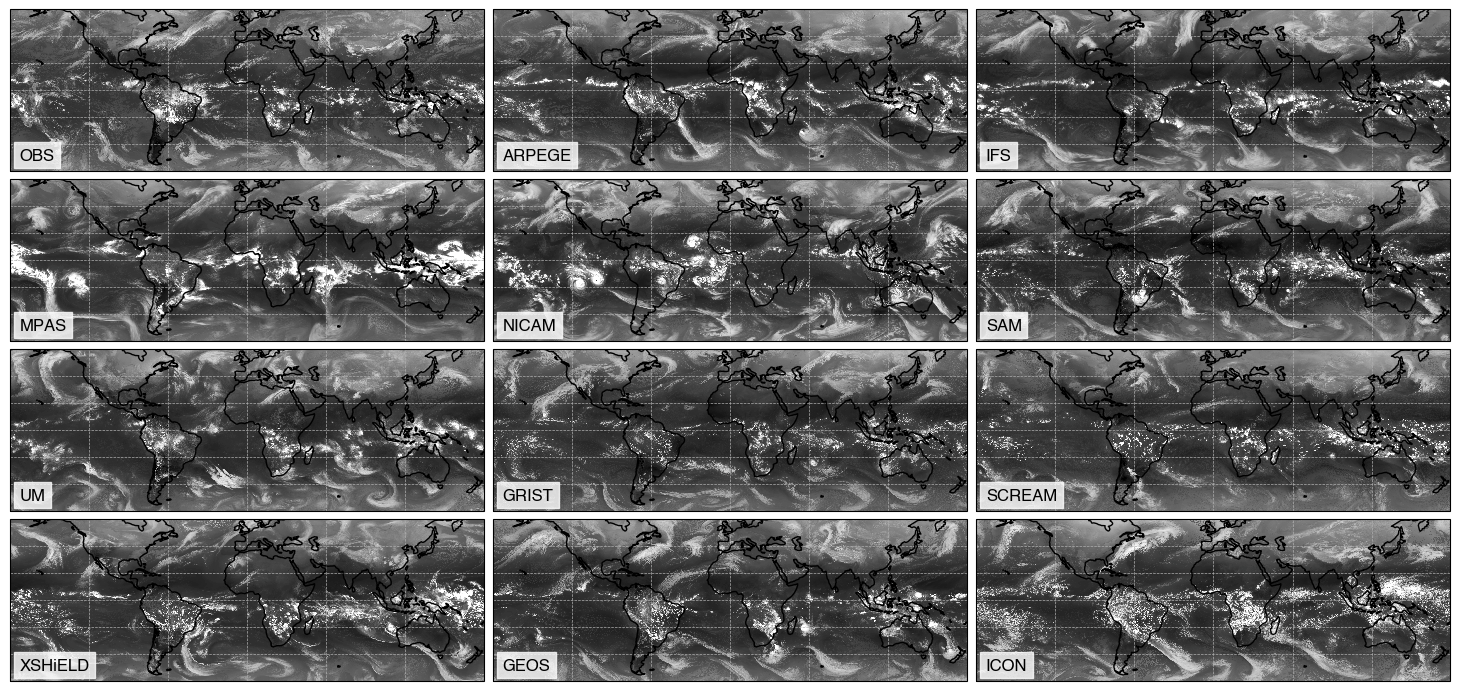

In [55]:
# nrow = 3
# nsource = len(name_map)
# ncol = np.ceil(nsource / nrow).astype(int)
ncol = 3
nsource = len(name_map)
nrow = np.ceil(nsource / ncol).astype(int)

figwidth = 16
height_ratio_per_panel = 0.35
figheight = nrow * (figwidth / ncol) * height_ratio_per_panel
figsize = [figwidth,figheight]
fontsize = 12
cb_fontsize = 10
varname1 = 'Tb'
# varname2 = '$\Delta$MCS Rain'
units = 'K'

# Select variable to plot
da = ds['Tb']
# levels = np.arange(200, 300, 1)
# cmaps = cc.cm['rainbow4']
levels = np.arange(210, 320, 1)
cmaps = cc.cm['gray_r']
titles = list(name_map.values())

cbticks = levels
oob_colors = None
# oob_colors = [{'under':'white', 'over':'firebrick'}] + [None]*nmodel
cblabels = [f'{varname1} ({units})']
text_colors = {'pos':'teal', 'neg':'darkgoldenrod'}

figname = f'{figdir}tb_snapshot_all_{sample_times}.png'

fig = plot_maps_nrow(nrow, ncol, da, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, 
                     figsize=figsize, fontsize=fontsize, cb_fontsize=cb_fontsize, contourf=False, oob_colors=oob_colors, show_cb2=False)
                     # boxes=boxes, boxtextloc=text_loc, dict_text_type=dict_text_type, dict_text_val=dict_text_val, text_colors=text_colors)

In [56]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Winter/figures/snapshots/tb_snapshot_all_2020-02-20T18.png'

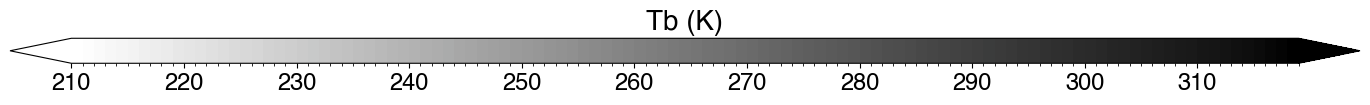

In [43]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
cmap = cc.cm['gray_r']
# oob_colors = {'under':'white', 'over':'firebrick'}
# cmap.set_over(oob_colors['over'])
# cmap.set_under(oob_colors['under'])
# levels = [1,2,3,5,7,10,13,16,20,25]
cbticks = np.arange(210, 321, 10)
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = 'Tb (K)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.ax.set_title(cblabel, size=20)
figname = f'{figdir}tb_snapshot_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')